# Multi-Bin Classifier

In [1]:
import copy
import collections
import sys

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import imblearn.pipeline

import sklearn.model_selection
import sklearn.multiclass
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib
import matplotlib.pyplot as plt

import sklearn.impute
import seaborn as sns

sys.path.append("../../../../")
import DigitalEcosystem.utils.figures

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Dataset

In [3]:
# Load up the data
data_path = "../../httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'exfoliation_energy_per_atom (eV/atom)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
target_column = ['bandgap (eV)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'

]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors#%%
target = ['bandgap (eV)']

# Featurization

Here, we use the Sine Matrix eigenspectrum (DScribe Documentation here: [Link](https://singroup.github.io/dscribe/0.3.x/tutorials/sine_matrix.html)) as our input feature to determine metallicity. We'd also tried the Ewald Summation Matrix eigenspectrum (DScribe Documentation here: [Link](https://singroup.github.io/dscribe/latest/tutorials/descriptors/ewald_sum_matrix.html)), but found that the Sine Matrix led to better performnance.

In [4]:
# Generate the Sine Matrix Fingerprint
max_atoms = max(data['atoms_object (unitless)'].apply(len))
sine_eigenspectrum = dscribe.descriptors.SineMatrix(n_atoms_max=max_atoms,
                                                         permutation='eigenspectrum',
                                                         sparse=False)
data['sine_matrix'] = data['atoms_object (unitless)'].progress_apply(lambda atoms: np.real(sine_eigenspectrum.create(atoms))).fillna(0)

100%|██████████| 6351/6351 [00:10<00:00, 632.07it/s]


Next, we'll label our data. We'll say that it's a metal if its DFT bandgap is less than 0.1 eV.

In [5]:
# Discretize the different parts of the bandgap
cutoffs = {
    "metals": (0, 0, 0.2),
    "semiconductors": (1, 0.2, 1.14), # Si is 1.14 at 302K
    "wide_bandgap": (2, 1.14, 3.4),
    "ultrawide_bandgap": (3, 3.4, 15)
}

def assign_bandgap_category(bandgap):
    for category, (label, low, high) in cutoffs.items():
        if low <= bandgap < high:
            return label
    else:
        raise ValueError
        
data['bandgap_category'] = data['bandgap (eV)'].apply(assign_bandgap_category)
    
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, stratify=data['bandgap_category'], random_state=RANDOM_SEED)

# Train/Test Split
Then, we'll split up our data into a training and testing set. We'll stratify our dataset to ensure the same proportion of metals are found in both the training and test set.

In [6]:
# Pull out the X and Y values
def get_x_y(df):
    x = np.nan_to_num(np.hstack([np.vstack(df['sine_matrix']), df[xenonpy_matminer_descriptors].to_numpy()]))
    y = df['bandgap_category'].to_numpy()
    return x,y
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

# SMOTE

To avoid contaminating our test set with information about the training set, we perform K-means SMOTE *after* the train/test split.

In [7]:
collections.Counter(train_y)

Counter({3: 490, 0: 2832, 2: 1488, 1: 905})

In [8]:
# Upsample the training set with SMOTE
smoter = imblearn.over_sampling.SMOTE(
    sampling_strategy='all',
    random_state=RANDOM_SEED
)
res_x, res_y = smoter.fit_resample(train_x, train_y)
collections.Counter(res_y)

Counter({3: 2832, 0: 2832, 2: 2832, 1: 2832})

# Hyperparameter Optimization

For this work, we'll use an XGBoost classifier. Several of its most important hyperparameters are tuned via Optuna, a Bayesian optimization framework implented in Python.

In addition to optimizing the hyperparameters, we'll also investigate the use of a scaler. Optuna can choose from the following options:
1. No scaler being applied
2. A Min/Max scaler
3. A StandardScaler

In [9]:
current_pipeline = None
best_pipeline = None

def keep_best_bandgap_model(study, trial):
    """
    Records the best bandgap model found so far
    """
    global best_pipeline
    try:
        if study.best_trial == trial:
            best_pipeline = current_pipeline
    except ValueError:
        pass

def objective(trial: optuna.Trial):
    global current_pipeline

    tr_x, val_x, tr_y, val_y = sklearn.model_selection.train_test_split(res_x, res_y, test_size=0.2, random_state=RANDOM_SEED)

    current_pipeline = sklearn.pipeline.Pipeline([
        ("MinMaxScaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Classifier", xgboost.sklearn.XGBClassifier(
                                               learning_rate=trial.suggest_float('learning_rate', 0, 1),
                                               min_split_loss=trial.suggest_float('min_split_loss', 0, 1),
                                               max_depth=trial.suggest_int('max_depth', 1, 100),
                                               min_child_weight=trial.suggest_float('min_child_weight', 0, 10),
                                               reg_lambda=trial.suggest_float('reg_lambda', 0, 2),
                                               reg_alpha=trial.suggest_float('reg_alpha', 0, 2),
                                               n_estimators=100,
                                               n_jobs=-1,
                                               objective='multi:softprob',
                                               use_label_encoder=False,
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-mlogloss')

    current_pipeline.fit(X=tr_x, y=tr_y,
                         **{
                            'XGB_Classifier__eval_set': [[val_x, val_y]],
                            'XGB_Classifier__eval_metric': 'mlogloss',
                            'XGB_Classifier__early_stopping_rounds': 5,
                            'XGB_Classifier__callbacks': [pruning_callback],
                            'XGB_Classifier__verbose': False,
                         })

    preds = current_pipeline.predict(val_x)
    pred_labels = np.rint(preds)
    f1 = sklearn.metrics.f1_score(val_y, pred_labels, average='macro')

    return f1

We'll run Optuna using its TPE Sampler (the default; documentation here: [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html)) with a random seed supplied. Additionally, we'll use the HyperBand pruner to prune trials that are not promising (Documentation link here: [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html)).

We choose the HyperBand pruner because it's demonstrated accelerate convergence faster than many of the other pruning techniques available in Optuna: [Blogpost Link](https://tech.preferred.jp/en/blog/how-we-implement-hyperband-in-optuna/)

In [10]:
study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed=RANDOM_SEED,
        warn_independent_sampling=True,
        consider_endpoints=True,
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='maximize',
)

[I 2021-08-20 10:39:14,179] A new study created in memory with name: no-name-4c187dac-1870-40f5-a0f1-6921870c2105


In [11]:
study.optimize(objective, n_trials=256, callbacks=[keep_best_bandgap_model])


[I 2021-08-20 10:39:17,524] Trial 0 finished with value: 0.7324398755098475 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832}. Best is trial 0 with value: 0.7324398755098475.
[I 2021-08-20 10:39:20,599] Trial 1 finished with value: 0.7300266379471264 and parameters: {'learning_rate': 0.2764642551430967, 'min_split_loss': 0.8018721775350193, 'max_depth': 96, 'min_child_weight': 8.759326347420947, 'reg_lambda': 0.7156345399157333, 'reg_alpha': 1.0019902510469174}. Best is trial 0 with value: 0.7324398755098475.
[I 2021-08-20 10:39:24,145] Trial 2 finished with value: 0.7573652869566175 and parameters: {'learning_rate': 0.6834629351721363, 'min_split_loss': 0.7127020269829002, 'max_depth': 38, 'min_child_weight': 5.611961860656249, 'reg_lambda': 1.0061663306156194, 'reg_alpha': 0.027536899181364483}. Best is trial 2 with value:

# ROC Curves

To assess model performance, we'll print out some ROC curves here.

Although we hold out a validation set in our objective function, we do not retrain the model on the entire training set, as this validation set was also used to control the early stopping of our XGBoost model (and thus helps guard against overfitting).

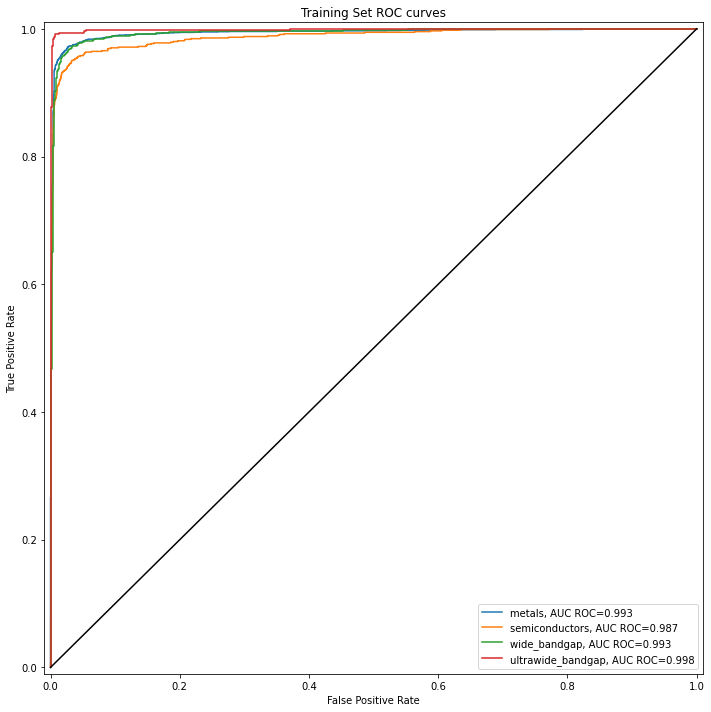

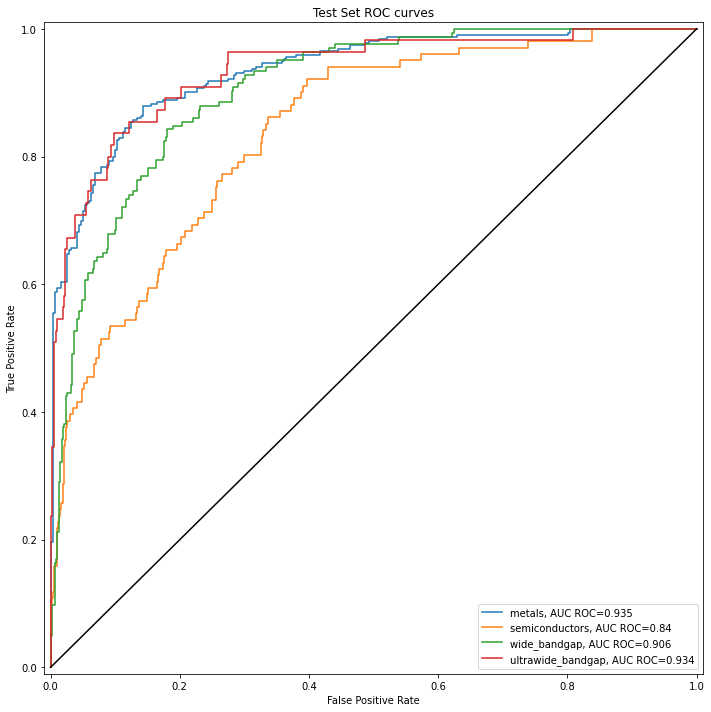

In [12]:
labels = {j[0]:i for (i,j) in cutoffs.items()}
plot_multi_roc = functools.partial(DigitalEcosystem.utils.figures.plot_multi_roc, classifier=best_pipeline)
                                   
plot_multi_roc(train_x, train_y, "Training", custom_labels=labels)
plot_multi_roc(test_x, test_y, "Test", custom_labels=labels)

# Confusion Matrices



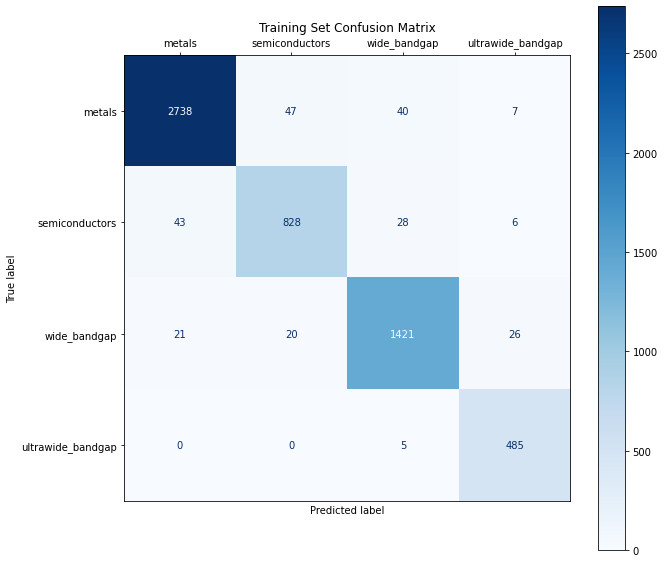

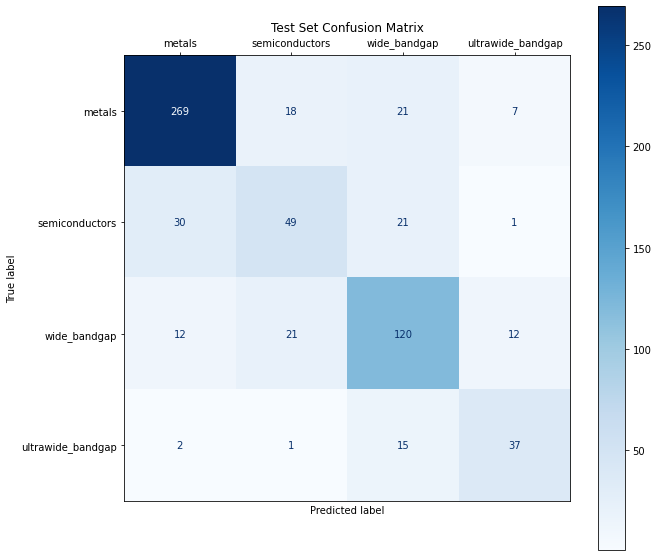

In [13]:
draw_confusion_matrix=functools.partial
def draw_confusion_matrix(x, y, label, classnames, classifier):
    plt.rcParams['figure.facecolor'] = 'white'
    sklearn.metrics.ConfusionMatrixDisplay(
        sklearn.metrics.confusion_matrix(
            y_true=y,
            y_pred=classifier.predict(x),
        )
    ).plot(cmap="Blues")
    plt.title(f"{label} Set Confusion Matrix")
    plt.xticks(range(len(classnames)), labels=classnames)
    plt.yticks(range(len(classnames)), labels=classnames)
    plt.gca().xaxis.tick_top()
    plt.savefig(f"{label}_set_confusion_matrix.png")
    plt.show()
    plt.close()

classnames = [key for key in cutoffs.keys()]
draw_confusion_matrix(train_x, train_y, "Training", classnames, best_pipeline)
draw_confusion_matrix(test_x, test_y, "Test", classnames, best_pipeline)